# Homework_Material_Energy_System_1-20250521 

Muhammad_Qasim_Anwar | M.Sc. PEESE 2024 | 506958 | TU Berlin


## Agenda:
- Scenario development
- Input data
- Create oemof model
- Optimize oemof model
- Access results

## Scenario development
#### Process of energy system modeling


<img src="jupyter_pics/process_of_energy_system_modeling.png" width="500">



### Exercise-01:
- The purpose of this homework is the modeling of a simple electricity-heat-based energy system with the Python library oemof.
- The overall aim is to develop step by step a model, which shall represent the energy system of Schleswig Holstein as accurate as possible.
- Create an oemof model of the energy system in which the model should consist of the following assets:
  - Technical components:
    - PV
    - Wind turbines
    - Electricity Storage
    - Heat Pump
    - Electricity demand and excess
    - Space heat and dhw heat demand and heat excess
- Electricity, Space Heat and Hot Water demand is given as timeseries data.
- Excess electricity and heat can be feed-in to an electricity grid and heat grid respectively without any feed-in tariffs.
- Electricity and heat import is not possible, the energy demand shall be covered by internal renewable resources.
- The model should analyze dispatch and sizing optimization.
- For sizing optimization use the investment mode.
- For the components PV, wind, storage and heat pump, investments are unlimited and no existing capacities shall be considered.
- Capex assumptions for all technologies are defined in excel input data assignment1.xls.
- Marginal costs are neglected.
- The heat pump efficiency of 3.90, represents the mean annual COP, the heat pump capex is specific to the thermal output power of 1.4 Mio €/MW
  thermal.

#### Energy system to be analyzed

<img src="jupyter_pics/Representation_of_the_Energy_System.JPG" width="600">

#### Energy system model: inputs and outputs

<img src="jupyter_pics/overview_model_setup.PNG" width="600">

## Input data 

Overview on Input data, defined in external Excel file
- Meteorological data
    - Timeseries of capacity factors of PV and Wind
    - Timeseries of normalized electricity, space heat and hot water demand
    
<img src="jupyter_pics/homework2_input_timeseries.JPG" width="500">


- System configuration technical data
    - Storage and Heat Pump technical parameter
    
<img src="jupyter_pics/homework2_input_tech.JPG" width="400">

  - Project description: General and economic data

<img src="jupyter_pics/homework2_input_costs.JPG" width="400">


### Read and plot input data 

- Input data is saved in 'input_data_assignement1.xls' in folder data, it contains
    - Hourly timeseries for 1 year of normalized electricty, space heat and hot water demand and capacity factors for PV and Wind turbine feed in in
      sheet 'timeseries'
    - Annual electricty, space heat and hot water demand in MWh in sheet 'capacities'
    - Cost data for all considered technologies in sheet 'costs'
    - Technical parameters in sheet 'tech'
- Use pandas.read_excel() function to read excel file
    - Documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

- Loaded data is timeseries data as **pandas.DataFrame**
    - Time series data consists of data points attached to sequential time stamps. 
    - https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html
 
 
**TASK**:

- Read each excel sheet in a separat DataFrame, called timeseries, capacities, tech and costs
- Plot timeseries data and print annual electricity demand

In [1]:
# Load libaries
import pandas as pd

#%% Read input data
# Timeseries Data Reading
timeseries = pd.read_excel('../data/input_data_assignment1.xls', 
                           sheet_name='timeseries', 
                           index_col=[0], 
                           parse_dates=True)
# Add timeindex frequency
timeseries.index.freq = '1h'

# Capacity Data Reading
capacities = pd.read_excel('../data/input_data_assignment1.xls', 
                           sheet_name='capacity', 
                           index_col=[0])

# Cost Data Reading
costs = pd.read_excel('../data/input_data_assignment1.xls', 
                           sheet_name='costs', 
                           index_col=[0])

# Tech Data Reading
tech = pd.read_excel('../data/input_data_assignment1.xls', 
                           sheet_name='tech', 
                           index_col=[0])


In [2]:
timeseries.index

DatetimeIndex(['2050-01-01 00:00:00+00:00', '2050-01-01 01:00:00+00:00',
               '2050-01-01 02:00:00+00:00', '2050-01-01 03:00:00+00:00',
               '2050-01-01 04:00:00+00:00', '2050-01-01 05:00:00+00:00',
               '2050-01-01 06:00:00+00:00', '2050-01-01 07:00:00+00:00',
               '2050-01-01 08:00:00+00:00', '2050-01-01 09:00:00+00:00',
               ...
               '2050-12-31 14:00:00+00:00', '2050-12-31 15:00:00+00:00',
               '2050-12-31 16:00:00+00:00', '2050-12-31 17:00:00+00:00',
               '2050-12-31 18:00:00+00:00', '2050-12-31 19:00:00+00:00',
               '2050-12-31 20:00:00+00:00', '2050-12-31 21:00:00+00:00',
               '2050-12-31 22:00:00+00:00', '2050-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timeindex', length=8760, freq='h')

array([<Axes: xlabel='timeindex'>, <Axes: xlabel='timeindex'>,
       <Axes: xlabel='timeindex'>, <Axes: xlabel='timeindex'>,
       <Axes: xlabel='timeindex'>], dtype=object)

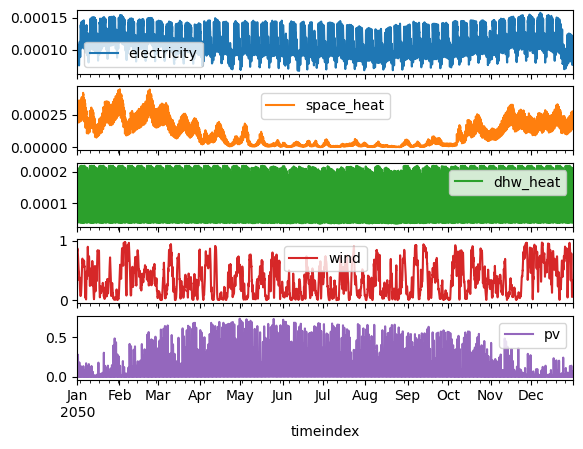

In [3]:
# Plot timeseries data
timeseries.plot(subplots=True)


In [4]:
# Print value of annual electricity demand
print('Annual electricty demand =', capacities['electricity']['amount'], 'MWh')

# Print value of annual space heat demand
print('Annual space heat demand =', capacities['space_heat']['amount'], 'MWh')

# Print value of annual hot water heat demand
print('Annual space hot water demand =', capacities['dhw_heat']['amount'], 'MWh')

Annual electricty demand = 18596726.5151087 MWh
Annual space heat demand = 18625912.608057 MWh
Annual space hot water demand = 4011619.38575441 MWh


## Create oemof model

**Buses:**
- Electricity Bus
- Heat Bus

**Components:**
- Photovoltaic (Source)
- Wind turbine (Source)
- Storage (Generic Storage)
- Heat Pump (Converter)

**Demand**
- Electricity demand (Sink)
- Space heat demand (Sink)
- Hot water demand (Sink)

**Excess**
- Electricity excess to main grid (Sink)
- Heat excess to heat grid (Sink)

**TASK:**
- Create a oemof graphical energy system model which specifies the most basic oemof classes
    - Components (Sink, Source, Generic Storage, Converter) and Bus

The correct oemof energysystem looks like this:
![oemof_EnergySystem_homework2.PNG](jupyter_pics/oemof_EnergySystem_homework2.PNG)


### Initialize energysystem
- Initialize your energy system called energysystem with a DatetimeIndex
    - You can use the index of our loaded timeseries data, as this is already formatted as Datetimeindex
    
    
- Necessary external libaries need to be loaded
    - oemof.solph
    
        - Documentation of oemof.solph: https://oemof-solph.readthedocs.io/en/latest/
        - Documentation how to use oemof.solph: https://oemof-solph.readthedocs.io/en/latest/usage.html#how-can-i-use-solph
        - Documentation of how to set up an energysystem model: https://oemof-solph.readthedocs.io/en/latest/usage.html#set-up-an-energy-system


In [5]:
# Load libaries
from oemof import solph
import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# We can use the index of our loaded timeseries data, as this is already formatted as Datetimeindex
print(timeseries.index)

#%% Initialize the energy system
energysystem = solph.EnergySystem(timeindex=timeseries.index)

DatetimeIndex(['2050-01-01 00:00:00+00:00', '2050-01-01 01:00:00+00:00',
               '2050-01-01 02:00:00+00:00', '2050-01-01 03:00:00+00:00',
               '2050-01-01 04:00:00+00:00', '2050-01-01 05:00:00+00:00',
               '2050-01-01 06:00:00+00:00', '2050-01-01 07:00:00+00:00',
               '2050-01-01 08:00:00+00:00', '2050-01-01 09:00:00+00:00',
               ...
               '2050-12-31 14:00:00+00:00', '2050-12-31 15:00:00+00:00',
               '2050-12-31 16:00:00+00:00', '2050-12-31 17:00:00+00:00',
               '2050-12-31 18:00:00+00:00', '2050-12-31 19:00:00+00:00',
               '2050-12-31 20:00:00+00:00', '2050-12-31 21:00:00+00:00',
               '2050-12-31 22:00:00+00:00', '2050-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timeindex', length=8760, freq='h')


### Create oemof bus

- All flows into and out of a Bus are balanced
- Therefore an instance of the Bus class represents a grid or network without losses
- To define an instance of a Bus only a unique label is necessary

**TASK:**
- Define Bus objects for electricity and heat with the unique label *electricty_l* and *heat_l* respectively
- Add defined Bus object to energysystem

In [8]:
#%% Create oemof Bus

# create electricity bus
bus_electricity = solph.buses.Bus(label='electricity_l')

# create heat bus
bus_heat = solph.buses.Bus(label='heat_l')

# add buses to energy model
energysystem.add(bus_electricity)
energysystem.add(bus_heat)

### Create oemof sinks
- Electricity demand
- Electricity excess
- Space heat demand
- Hot water demand
- Heat excess

#### Definition of Flows
- The flow class has to be **used to connect**. 
- An instance of the Flow class is normally used in **combination with the definition of a component**.
- We will use the defined bus objects and flow objects for input and output definitions of further Source, Sink, GenericStorage and Heatpump objects.

- Documentation: https://oemof-solph.readthedocs.io/en/latest/reference/oemof.solph.flow.html


####  Definition of Sink objects
- A Sink is connected with **1 input flow**.
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#sink-basic
- Use your defined Bus object for input and connect it via a Flow object with the electricity, space heat and hot water demand respectively.
    Use the load demand timeseries data we loaded from the Excel file.

*Electricity demand:* Input is defined by electricity Bus which is connected via the Flow class with the excel electricity demand data. 
- Define the Flow class.
    - Define fix with the loaded timeseries of normalized electricity demand
    - Define nominal_value with the total annual electricty demand defined in capacities
    - Use the loaded timeseries data with the electricty demand.
    
*Electricity excess:* As electricty demand but with a empty Flow() 

*Space heat and hot water demand:* Input is defined by electricity Bus which is connected via the Flow class with the excel space heat and hot water demand data. 
- Define the Flow class.
    - Define fix with the loaded timeseries of normalized space heat and hot water demand
    - Define nominal_value with the total annual space heat and hot water demand defined in capacities
    - Use the loaded timeseries data with the space heat and hot water demand.
    
*Heat excess:* As space heat and hot water demand but with a empty Flow()
        
**TASK:**
- Define the electricty demand and electricty excess Sink objects with the defined electricity Bus and Flow and the imported csv data.
- Define the space heat, hot water demand and heat excess Sink objects with the defined heat Bus and Flow and the imported csv data.

In [9]:
#%% Create oemof Sinks

# create simple sink object representing the electrical demand
electricity_demand = solph.components.Sink(label='electricity_demand_l',
                                inputs={bus_electricity: solph.Flow(fix=timeseries['electricity'], 
                                                                    nominal_value=capacities['electricity']['amount'])
                                       }
                               )

# create excess component for the electricity bus to allow overproduction
electricity_excess = solph.components.Sink(label='electricty_excess_l', 
                                inputs={bus_electricity: solph.Flow()}
                               )

# create simple sink object representing the heat demand
space_heat_demand = solph.components.Sink(label='space_heat_demand_l',
                                inputs={bus_heat: solph.Flow(fix=timeseries['space_heat'], 
                                                                    nominal_value=capacities['space_heat']['amount'])
                                       }
                               )
dhw_heat_demand = solph.components.Sink(label='dhw_heat_demand_l',
                                inputs={bus_heat: solph.Flow(fix=timeseries['dhw_heat'], 
                                                                    nominal_value=capacities['dhw_heat']['amount'])
                                       }
                               )

# create excess component for the heat bus to allow overproduction
heat_excess = solph.components.Sink(label='heat_excess_l', 
                                inputs={bus_heat: solph.Flow()}
                               )

# All sinks to the energysystem
energysystem.add(electricity_excess, electricity_demand, heat_excess, space_heat_demand, dhw_heat_demand)

### Create oemof sources
- Wind turbine
- PV

#### Definition of source objects with investent mode (sizing optimization)
- A Source has **1 output flow**.
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#source-basic
    - Use the capacity factor timeseries for PV and Wind we already loaded from the Excel file
    
    

- As the installation of new capacities of the sources Wind turbine and PV are associated with costs the **Investment mode** needs to be integrated!
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#investment-optimisation
- We consider for this exercise only capacity costs (with capex but without fixed opex) and no marginal costs (variable opex) for additional installed capacities
    - Wind: Capacity costs = 1,075,000.0 €/MW, lifetime = 20 years, WACC = 0.05
    - PV: Capacity costs = 425,000.0 €/MW, lifetime = 20 years, WACC = 0.05
    
- Calculate the capital costs, which are the annuity of capital costs (capex) for all the components Wind and PV.


In [10]:
# Import economic libary
from oemof.tools import economics

#%% Economic calculation (for sizing optimization)

# Define capacity costs with oemof.tools.economics.annuity function
# Equivalent periodical costs (epc) of an investment are equal to the annuity in case of 1year simulation
cc_wind = economics.annuity(capex=costs['wind']['capex'], 
                            n=costs['wind']['lifetime'],
                            wacc=costs['wind']['wacc'])

cc_pv = economics.annuity(capex=costs['pv']['capex'], 
                            n=costs['pv']['lifetime'],
                            wacc=costs['pv']['wacc'])


 - Define the sources PV and Wind with the integrated investment
 
**TASK:**
-  Define the PV source object

In [11]:
#%%Create oemof Sources

# create fixed source object representing wind power plants
wind = solph.components.Source(label='wind_l',
                    outputs={bus_electricity: solph.Flow(fix=timeseries['wind'], 
                                                         investment=solph.Investment(ep_costs=cc_wind)
                                                        )
                            }
                   )

# create fixed source object representing pv power plants
pv = solph.components.Source(label='pv_l',
                  outputs={bus_electricity: solph.Flow(fix=timeseries['pv'], 
                                                       investment=solph.Investment(ep_costs=cc_pv)
                                                      )
                           }
                 )

# Add sources to the energysystem
energysystem.add(wind, pv)
               

### Create oemof GenericStorage
- Storage 


#### Definition of GenericStorage objects with investent mode (sizing optimization)
- The GenericStorage is designed for **1 input and 1 output**.
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#genericstorage-component
   
   

- As the GenericStorage Storage component is associated with costs the **Investment mode** needs to be integrated!
- We consider for this exercise only capacity costs (with capex but without fixed opex) and no marginal costs (variable opex)
    - Storage: Capacity costs = 200,000.0 €/MWh, lifetime = 20 years, WACC = 0.05
- Calculate the capital costs, which are the annuity of capital costs (capex) for the storage component

In [12]:
#%% Economic calculation (for sizing optimization)

# Define capacity costs with oemof.tools.economics.annuity function
# Equivalent periodical costs (epc) of an investment are equal to the annuity in case of 1year simulation

cc_storage = economics.annuity(capex=costs['storage']['capex'], 
                               n=costs['storage']['lifetime'],
                               wacc=costs['storage']['wacc'])

#### Further parameter need to be consider when using the Investment mode with a GenericStorage
- It needs to be considered, that it is possible to
    - invest into the flow parameter of the storage e.g. turbine/pump or battery management system
    - Invest into the capacity of the storage e.g. basin or battery cell
  
    
- In order to keep our model simple, we set the following parameters:
    - *invest_relation_input_capacity = 1* fixes the input flow investment to the capacity investment. The value of 1 means that the storage can be filled within one time-period.
    - *invest_relation_output_capacity = 1* fixes the output flow investment to the capacity investment. The value of 1 means that the storage can be emptied within one period.


- We assume following technical storage parameters:
    - Initial storage content empty --> initial_storage_level=0
    - No self-discharge --> loss_rate=0 
    - Charging efficiency 1 --> inflow_conversion_factor=1
    - discharging efficiency 0.8 --> outflow_conversion_factor=0.8  
    
**TASK:**
- Define the technical parameters within the oemof storage object.

In [13]:
#%% Create oemof Storage

# create storage object representing a battery
storage = solph.components.GenericStorage(label='storage_l',
                                          inputs={bus_electricity: solph.Flow()},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['storage']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['storage']['max_hours'],
                                          invest_relation_output_capacity=1/tech['storage']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['storage']['efficiency'],
                                          investment=solph.Investment(ep_costs=cc_storage)
                                         )

# Add storage to the energysystem
energysystem.add(storage)   

### Create oemof Converter
- Heat Pump 


#### Definition of Converter objects with investent mode (sizing optimization)
- The Converter is designed for **1 input from electricity bus and 1 output to heat bus**.
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#converter-basic
   
   

- As the Converter Heat Pump component is associated with costs the **Investment mode** needs to be integrated!
- We consider for this exercise only capacity costs (with capex but without fixed opex) and no marginal costs (variable opex)
    - Heat Pump: Capacity costs = 1,400,000.0 €/MW, lifetime = 20 years, WACC = 0.05
- Calculate the capital costs, which are the annuity of capital costs (capex) for the Heat Pump component

In [14]:
#%% Economic calculation (for sizing optimization)

# Define capacity costs with oemof.tools.economics.annuity function
# Equivalent periodical costs (epc) of an investment are equal to the annuity in case of 1year simulation

cc_hp = economics.annuity(capex=costs['hp']['capex'], 
                               n=costs['hp']['lifetime'],
                               wacc=costs['hp']['wacc'])

In [15]:
#%% Create oemof Converter

# The cop (coefficient of performance) of the heat pump can be defined as
# a scalar or a sequence.

cop = 3.90

hp = solph.components.Converter(
    label='hp_l',
    inputs={
        bus_electricity: solph.Flow()
    },
    outputs={
        bus_heat: solph.Flow(investment=solph.Investment(ep_costs=cc_hp))
    },
    conversion_factors={
        bus_electricity: 1/cop,
        bus_heat: (cop - 1)/cop
    },
    
)

# Add Converter to the energy system
energysystem.add(hp)

## Optimize oemof model

- Define optimization model via solph.Model()
- Solve the optimization problem with the definition of the used solver and call attribute model.solve()
    - use cbc solver


## Optimize oemof model

- Define optimization model via solph.Model()
- Solve the optimization problem with the definition of the used solver and call attribute model.solve()
    - use cbc solver


In [16]:
#%% Optimise the energy system
# initialise the operational model
om = solph.Model(energysystem)

# if tee_switch is true solver messages will be displayed
om.solve(solver='cbc')

{'Problem': [{'Name': 'unknown', 'Lower bound': 7066463382.0, 'Upper bound': 7066463382.0, 'Number of objectives': 1, 'Number of constraints': 87610, 'Number of variables': 78853, 'Number of nonzeros': 3, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 3.99, 'Wallclock time': 3.99, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 5543}}, 'Error rc': 0, 'Time': 4.18036961555481}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [17]:
# Store optimization results
#energysystem.results['main'] = solph.processing.results(om)

energysystem.dump('../results/dumps',
                  filename='model.oemof')

'Attributes dumped to: ../results/dumps\\model.oemof'

 ## Access results
 - Results could be restored from oemof file if model was not run just before.
 - For easy handling of results use 
     - solph.processing.results()
     - solph.views.node()  

#### solph.processing.results() function:
- Use solph.processing.results() function
    - Documentation: https://oemof-solph.readthedocs.io/en/latest/usage.html#results-collect-results-label
- Gives back the results as a python dictionary holding **pandas Series for scalar values** and **pandas DataFrames for all nodes and flows** between them.
- You can directly extract the data in the dictionary by using these keys, where “node” is the name of the object you want to address. 
    - you can use specified *component_label* to access the component data - '*component_label*' (use quotes)
    - you can use specified *component_parameter_name* to access the component data - *component_parameter_name*
- The keys of the results dictionary are tuples containing two nodes. Since flows have a starting node and an ending node

#### solph.views.node() function:
- An **easy access** of the results can be done via oemof.views.node()
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#results-easy-access-label
- Easily one specific DataFrame can be extracted from us with the definition of the defined key.

dict_keys([("<oemof.solph.buses._bus.Bus: 'electricity_l'>", "<oemof.solph.components._sink.Sink: 'electricity_demand_l'>"), ("<oemof.solph.buses._bus.Bus: 'electricity_l'>", "<oemof.solph.components._sink.Sink: 'electricty_excess_l'>"), ("<oemof.solph.buses._bus.Bus: 'electricity_l'>", "<oemof.solph.components._converter.Converter: 'hp_l'>"), ("<oemof.solph.buses._bus.Bus: 'electricity_l'>", "<oemof.solph.components._generic_storage.GenericStorage: 'storage_l'>"), ("<oemof.solph.buses._bus.Bus: 'heat_l'>", "<oemof.solph.components._sink.Sink: 'dhw_heat_demand_l'>"), ("<oemof.solph.buses._bus.Bus: 'heat_l'>", "<oemof.solph.components._sink.Sink: 'heat_excess_l'>"), ("<oemof.solph.buses._bus.Bus: 'heat_l'>", "<oemof.solph.components._sink.Sink: 'space_heat_demand_l'>"), ("<oemof.solph.components._converter.Converter: 'hp_l'>", "<oemof.solph.buses._bus.Bus: 'heat_l'>"), ("<oemof.solph.components._source.Source: 'pv_l'>", "<oemof.solph.buses._bus.Bus: 'electricity_l'>"), ("<oemof.solph.co

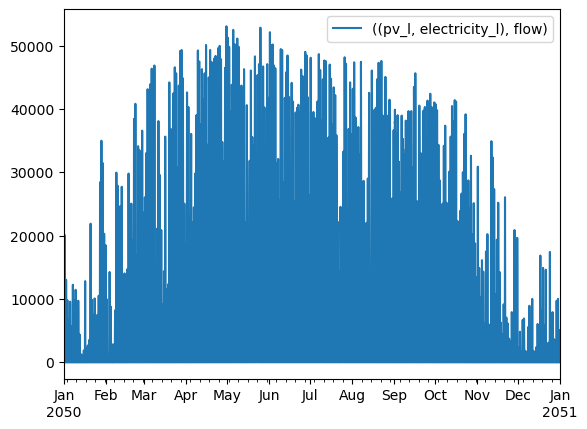

In [18]:
#%% Extract results 
# Extract results with processing module from model
results = solph.processing.results(om)
# Print all keys of result dictionary
print(results.keys())

# Extract component results dict with used component labels
results_pv = solph.views.node(results, 'pv_l')
results_wind = solph.views.node(results, 'wind_l')
results_storage = solph.views.node(results, 'storage_l')
results_hp = solph.views.node(results, 'hp_l')
print(results_pv)

# Extract timeseries data of flow
results_pv_ts = results_pv['sequences']
results_pv_ts.plot()

# Extract investment in component capacity
results_pv_cap = results_pv['scalars'][('pv_l', 'electricity_l'), 'invest']
print('results_pv_cap', results_pv_cap)
results_wind_cap = results_wind['scalars'][('wind_l', 'electricity_l'), 'invest']
print('results_wind_cap', results_wind_cap)
results_storage_cap = results_storage['scalars'][('storage_l', 'electricity_l'), 'invest']
print('results_storage_cap', results_storage_cap)
results_hp_cap = results_hp['scalars'][('hp_l', 'heat_l'), 'invest']
print('results_hp_cap', results_hp_cap)

# Alternative access with component parameter names
# But stick to one mode via labels or component names, otherwise you run into problems!
#results_pv = solph.views.node(results, pv)

### Exercise-02:
- Extract the optimized investments of PV, wind in MW, of storage in MWh, and heat pump in MW thermal output power.
- Extract the amount of electricity generated by PV and wind turbines and the heat generated by the heat pump in TWh.
- Extract the amount of excess electricity and excess heat in TWh.

In [ ]:
# Extract processed results
results = solph.processing.results(om)

# Views for each component
results_pv = solph.views.node(results, 'pv_l')
results_wind = solph.views.node(results, 'wind_l')
results_storage = solph.views.node(results, 'storage_l')
results_hp = solph.views.node(results, 'hp_l')
bus_el = solph.views.node(results, 'electricity_l')
bus_heat = solph.views.node(results, 'heat_l')

# === INVESTMENTS ===
results_pv_cap = results_pv['scalars'][(('pv_l', 'electricity_l'), 'invest')]
results_wind_cap = results_wind['scalars'][(('wind_l', 'electricity_l'), 'invest')]
results_storage_cap = results_storage['scalars'][(('storage_l', 'electricity_l'), 'invest')]
results_hp_cap = results_hp['scalars'][(('hp_l', 'heat_l'), 'invest')]

print("📦 Optimized Investments:")
print(f"PV: {results_pv_cap:.2f} MW")
print(f"Wind: {results_wind_cap:.2f} MW")
print(f"Storage: {results_storage_cap:.2f} MWh")
print(f"Heat Pump: {results_hp_cap:.2f} MW thermal")

# === ENERGY GENERATED OR EXCESSED (TWh) ===
pv_gen = results_pv['sequences'][(('pv_l', 'electricity_l'), 'flow')].sum() / 1e6
wind_gen = results_wind['sequences'][(('wind_l', 'electricity_l'), 'flow')].sum() / 1e6
heat_gen = results_hp['sequences'][(('hp_l', 'heat_l'), 'flow')].sum() / 1e6

elec_excess = bus_el['sequences'][(('electricity_l', 'electricty_excess_l'), 'flow')].sum() / 1e6
heat_excess = bus_heat['sequences'][(('heat_l', 'heat_excess_l'), 'flow')].sum() / 1e6

print("\n⚡ Annual Energy Outputs:")
print(f"PV Generation: {pv_gen:.3f} TWh")
print(f"Wind Generation: {wind_gen:.3f} TWh")
print(f"Heat Pump Output: {heat_gen:.3f} TWh")
print(f"Excess Electricity: {elec_excess:.3f} TWh")
print(f"Excess Heat: {heat_excess:.3f} TWh")

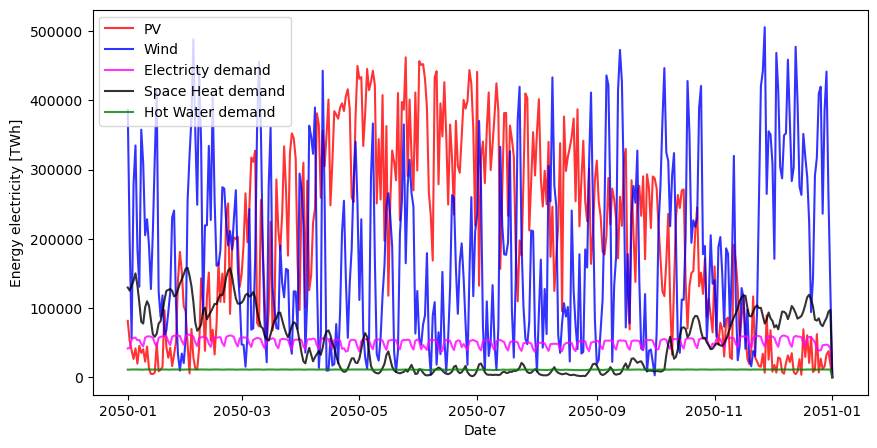

In [370]:
import matplotlib.pyplot as plt

#%% Lineplot
results_pv_ts = results_pv['sequences']
results_wind_ts = results_wind['sequences']
elec_demand_ts = solph.views.node(results, 'electricity_demand_l')['sequences']
space_heat_demand_ts = solph.views.node(results, 'space_heat_demand_l')['sequences']
dhw_heat_demand_ts = solph.views.node(results, 'dhw_heat_demand_l')['sequences']

# Resample timestep to wished step
# 'D'=Days, 'M' Months, 'Y' Years, also possile to specify multiple days e.g. '7D'
freq_sample = 'D'
# Resample timeseries data
elec_pv_rs1 = results_pv_ts.resample(freq_sample).sum()
elec_wind_rs1 = results_wind_ts.resample(freq_sample).sum()
elec_demand_rs1 = elec_demand_ts.resample(freq_sample).sum()
space_heat_demand_rs1 = space_heat_demand_ts.resample(freq_sample).sum()
dhw_heat_demand_rs1 = dhw_heat_demand_ts.resample(freq_sample).sum()

# Define figure with figsize
fig = plt.figure(figsize=(10,5))
# Define transparency level of plot 
set_alpha=0.8

# Plot resampled timeseries of components
plt.plot(elec_pv_rs1, alpha=set_alpha, color='red', label='PV')
plt.plot(elec_wind_rs1, alpha=set_alpha, color='blue', label='Wind')
plt.plot(elec_demand_rs1, alpha=set_alpha, color='magenta', label='Electricty demand')
plt.plot(space_heat_demand_rs1, alpha=set_alpha, color='black', label='Space Heat demand')
plt.plot(dhw_heat_demand_rs1, alpha=set_alpha, color='green', label='Hot Water demand')

# Add legend
plt.legend()
# Add labels
plt.ylabel('Energy electricity [TWh]')
plt.xlabel('Date')

plt.show()
# Save figure
fig.savefig('../results/analysis_electricity_lp.png', dpi=300)

### Exercise-03:
What kind of problems do you see regarding results of the previous question. Is the model yet a realistic representation of Schleswig-Holsteins future energy system? Are investment results realistic? What kind of model improvements do you propose?

### Interpretation of Results and Model Realism

After solving the energy system model, the optimized investment results show significant scaling of renewable generation and storage. The system heavily relies on photovoltaic (PV) and wind power, with large battery storage and a sizable heat pump system to cover heat demand. While the model ran successfully and provides internally consistent outputs, several results raise questions about real-world feasibility and system design assumptions.

#### 01-Observations from Optimization Results:
- **PV investment** reached approximately **72 GW**, and **wind investment** about **22 GW**.
- **Electricity storage** was sized at **103 GWh**, and the **heat pump** reached over **9 GW** of thermal capacity.
- Annual generation included **74.9 TWh** from PV and **67.3 TWh** from wind.
- The **heat pump** supplied **22.6 TWh** of heat to meet heating demands.
- **Excess electricity** amounted to **115.3 TWh**, while **excess heat** was **0 TWh**, indicating no thermal overproduction.

#### 02-Critical Issues Identified:
1. **Overinvestment in generation capacity**  
   Despite being lower than previous iterations, the installed capacity of renewables is still very high. The optimizer was not constrained by budget, land use, or technical limitations, leading to an economically unrealistic scale.

2. **High levels of electricity curtailment**  
   More than 100 TWh of renewable electricity is not used, indicating a mismatch between supply and system flexibility. This suggests the need for better load balancing or export strategies.

3. **No export or grid interconnection modeled**  
   Schleswig-Holstein is not an isolated region in reality. The model currently lacks a connection to external power markets or neighboring grids, which could absorb surplus energy and reduce curtailment.

4. **Static and simplified heat demand**  
   The heating demand profiles do not reflect real seasonal variation, especially higher loads in colder months. A flat profile results in oversized heat pump capacity.

6. **No thermal storage or buffering**  
   All generated heat must be used immediately, which is not realistic. Introducing thermal storage would allow for smaller heat pump investments and reduce electricity oversizing.

7. **No operational costs or emissions constraints**  
   The model only minimizes capital costs. Adding CO₂ constraints, marginal generation costs, and other economic or environmental metrics would make investment results more aligned with practical and policy-relevant decisions.

#### 03-Proposed Improvements:
- Add a **grid export** or market coupling component to better reflect interconnection.
- Introduce **budget constraints or land area limits** to limit oversizing.
- Use **realistic, time-dependent heating profiles** to reflect seasonal variability.
- Add **thermal storage** for space and DHW demands to reduce instantaneous capacity needs.
- Implement **CO₂ targets and marginal costs** to align investment decisions with decarbonization goals.
- Evaluate **curtailment penalties or incentives** to better shape generation flexibility.

---

Addressing these areas would significantly improve the realism of the model and make it more relevant for evaluating future energy systems in Schleswig-Holstein or similar regions.

## Conversion from Jupyter to Spyder

- Spyder IDL has the advantage of having a variable explorer and better grafical interface for system analysis
- Go to *file* - *Download as* and download is as *Python file* with the py extension.
- Open this file in the Spyder IDE.